# Programming Challenge

Josep Reverter Sancho

Saturday, April 6th

As described in the problem README, the goal is to **obtain the average income per person** for each of the **operating zones**, based on the publicly available information from the National Institute of Statistics (INE), which allows us to know the income level for each of the different census sections in Spain.

To do this calculation, as also described in the problem statement, we have four main tables:
- atlas_socioeconomico: gives us information about the average income per person for each census section (we will use the latest net income).
- poblacion_sec_censal: where we can obtain the population for each census section.
- zonas_censales_ine: geographical information about **census sections**
- zonas_operador: geographical information about **operating zones**

Basically, what is asked to us is to calculate the average income per person of every **operating zone**, given the average income and population of every **census section**, that are at a smaller geographical level (each operating section can have one or more census sections).

To solve the programming problem, we will follow the following steps:
1. Data preparation and preprocessing
2. Definition of the calculation of average (since, as described in the problem statement, we should not take the average of the income of all census sections that are into an operator section).
3. Definition of which census sections consider as part of operating zones and average calculus.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

pd.set_option('display.max_columns', None)

## 1. Data Preparation and Preprocessing

In [2]:
# atlas socioeconomico reading (net income information) and cleaning
df_atlas = pd.read_excel("atlas_socioeconomico.xlsx", header=7, usecols="A,B").rename(columns={" ":"section", "2017":"rent2017"})
df_atlas = df_atlas.dropna().reset_index(drop=True)

# filtering only census section information
df_atlas = df_atlas[df_atlas["section"].str.contains(r'^\d{10}\b')]

# creating section code
df_atlas_sections = df_atlas.copy()
df_atlas_sections[ "section_code"] = df_atlas_sections["section"].str[:10]
df_atlas_sections.head()

,section,rent2017,section_code
2,0100101001 Alegría-Dulantzi sección 01001,,0100101001
3,0100101002 Alegría-Dulantzi sección 01002,,0100101002
6,0100201001 Amurrio sección 01001,,0100201001
7,0100201002 Amurrio sección 01002,,0100201002
8,0100201003 Amurrio sección 01003,,0100201003


In [3]:
# loading population information
pop = pd.read_csv("poblacion_sec_censal.csv", encoding="latin-1", sep=";", dtype={"Total":str})

# ensuring Sección and Total are in a correct format. For Total, not float or points ".".
pop["Total"] = pop["Total"].str.replace(".","").astype(int)
pop["Sección"] = pop["Sección"].astype("str").str.zfill(10)
pop.head()

,Sexo,Sección,Edad (grupos quinquenales),Total
0,Ambos Sexos,0800101001,Total,1497
1,Ambos Sexos,0800101002,Total,1868
2,Ambos Sexos,0800101003,Total,835
3,Ambos Sexos,0800101004,Total,1922
4,Ambos Sexos,0800101005,Total,1844


In [4]:
# here we merge census section income with its population, and we obtain a unified dataframe with only the important information
df = pd.merge(df_atlas_sections, pop[["Sección", "Total"]], left_on="section_code", right_on="Sección").drop(columns=["Sección"]).rename(columns={"Total":"population"})
df.head()


,section,rent2017,section_code,population
0,0800101001 Abrera sección 01001,13380,0800101001,1497
1,0800101002 Abrera sección 01002,11975,0800101002,1868
2,0800101003 Abrera sección 01003,15283,0800101003,835
3,0800101004 Abrera sección 01004,14263,0800101004,1922
4,0800101005 Abrera sección 01005,12536,0800101005,1844


In [5]:
# here it is loaded the geographical information of census sections
with open('zonas_censales_ine.json', 'r') as f:
    data = json.load(f)
df_zones = pd.json_normalize(data["features"], sep="_")

# drop all columns unless the importants and changing column name to standaryze
df_zones = df_zones.drop(columns=set(df_zones.columns) - set(["geometry_coordinates","properties_CUSEC", "properties_CPRO", "properties_CMUN"])).rename(columns={"properties_CUSEC":"section_code"})
df_zones = df_zones[(df_zones["properties_CPRO"]=="08")].reset_index(drop=True)

In [6]:
# preprocessing of the coordinates defining a census section, so that Polygon and MultiPolygon can correctly interpret the information.
polygons = []
for i in range(0,len(df_zones)):
    if len(df_zones.geometry_coordinates[i]) > 1:
        if len(df_zones.geometry_coordinates[i][0]) == 1:
            polygons_list = [Polygon(df_zones.geometry_coordinates[i][j][0]) for j in range(0,len(df_zones.geometry_coordinates[i]))]
        else:
            polygons_list = [Polygon(df_zones.geometry_coordinates[i][j]) for j in range(0,len(df_zones.geometry_coordinates[i]))]

        polygons.append(MultiPolygon(polygons_list))
    else:
        polygons.append(Polygon(df_zones.geometry_coordinates[i][0]))

# creating the corresponding GeoDataFrame
gdf_sections = gpd.GeoDataFrame(df_zones, geometry=polygons)
gdf_sections.drop(columns=["geometry_coordinates", "properties_CMUN","properties_CPRO"], inplace=True)

In [7]:
# loading geographical geometry of operating zones
gdf = gpd.read_file('zonas_operador.geojson').drop(columns=["Coloration","C0","C1","ZE","Surface","TauxConcav", "Lac-CellId"])
gdf.head()


,Index,Population,geometry
0,10113,17520,"MULTIPOLYGON (((2.15650 41.35266, 2.15465 41.3..."
1,10115,38090,"MULTIPOLYGON (((2.16467 41.37754, 2.16785 41.3..."
2,10114,22000,"MULTIPOLYGON (((2.17640 41.37302, 2.17385 41.3..."
3,10125,22923,"MULTIPOLYGON (((2.18313 41.37160, 2.18208 41.3..."
4,10124,14739,"MULTIPOLYGON (((2.18690 41.36149, 2.18541 41.3..."


In [8]:
# some of the polygons are invalid, due to some constraints about the data, we try to fix them
invalid_sections = gdf_sections[gdf_sections.is_valid==False]
gdf_sections.loc[gdf_sections.is_valid==False, 'geometry'] = invalid_sections.buffer(0)
gdf = gdf[gdf.is_valid].reset_index(drop=True)

# we assign that the crs is EPSG:3857, as it is more reliable to calculate areas
gdf.crs = "EPSG:3857"
gdf = gdf.to_crs("EPSG:3857")

gdf_sections.crs = "EPSG:3857"
gdf_sections = gdf_sections.to_crs("EPSG:3857")

In [9]:
gdf["operating_geometry"] = gdf["geometry"]

# here we merge the operating zones with census sections. We assign for each census section, the operating zones that it intercepts
# 'within' method will exclude census sections that are partially outside a operating zone, and we don't want that, as we will loose information
joined = gpd.sjoin(gdf_sections, gdf, how="inner", predicate='intersects').reset_index(drop=True)

# defining crs as before
joined.crs = "EPSG:3857"
joined = joined.to_crs("EPSG:3857")

# calculate the area of a census section and the area of intersection with the operating zones, as well as the percentage of intersection
joined['census_area'] = joined.geometry.area
joined['intersection_area'] = joined.geometry.intersection(joined['operating_geometry']).area
joined["intersection_pct"] = joined["intersection_area"] / joined["census_area"]

# finally, we merge this geographical data with the income and population data
df_total = pd.merge(joined, df, on="section_code", how="left")
print(len(df_total[df_total.population.isna()]), "census sections don't match with the income and population data")
df_total = pd.merge(joined, df, on="section_code", how="inner")

34 census sections don't match with the income and population data


Now that we have preprocessed and merged all the data, we have a unified dataframe with all the intersections between census section and operating zones, with information about the intersection (area and percentage), and the population and average income for every census sections.

Note: this table *df_total* is not at census section level. Each row of this table is a intersection between census sections and operating zones.

In the following Folium map, we can see graphically what we have.

In [10]:
import folium

operating_zones = df_total[["operating_geometry"]].drop_duplicates()
census_sections = df_total[["geometry"]].drop_duplicates()

m = folium.Map([41.3851, 2.1734], zoom_start=14, tiles="cartodbpositron")

for index, row in census_sections.iterrows():
    polygon = folium.GeoJson(row["geometry"])
    m.add_child(polygon)

for index, row in operating_zones.iterrows():
    polygon = folium.GeoJson(row["operating_geometry"], color="green")
    m.add_child(polygon)

m

## 2. How to calculate the mean

Before going to further calculations, an important aspect to consider to solve the problem is how to calculate the average net income per operating zone given N census sections belonging completely to it.

As commented in the problem statement, the average net income per operating zone should not be calculated as the mean of the incomes of each census section. The example is very clear: if a census section A has 100 inhabitants and €100,000 average income per person, and a census section B has 100,000 inhabitants and 10,000 average income per person, if we do a simple mean, we will obtain that the operating zone will have an average income of 55,000€, and it is not true.

This method of calculation is highly susceptible to being affected by high values or outliers, which could be census sections with high incomes but few inhabitants. This wouldn't be fair, as a zone with 100 inhabitants shouldn't have the same impact as a zone with 100,000.

Hence, **the correct way to calculate the average is the following**: given the average income per person and the number of inhabitants, we can calculate the total income of a census section. Once we have the total income, we can add it to the other census sections of the same operating zone, giving us the total income of an operating zone. On the same way, we can also obtain the sum of inhabitants of a operating zone. Finally, with the total income of an operating zone and the total inhabitats, if we devide the total income / total inhabitants, we obtain the average income per person of an operating zone.



## 3. Which Census Sections consider as part of Operating Zones and Average Net Income calculus

Now that we have defined how we will calculate the average net income per person of every operating zone given N census sections, **we are going to decide how we consider census sections to be within an operating zone**, and how to deal with census sections that belong to different operating zones (if there are).

In the following plots, we can see two examples of operating zones, along with their respective census sections that intersect.

In the left plot, we can see census sections that are completely outside of the operating zone, which will have a negligible percentage of overlap, and their information should not affect the calculation of the operating zone's average net income per person.

In the same plot, we can observe a zone where the percentage of overlap is larger (the one furthest to the right), and therefore, it might have an effect. In this case, we can think that it's an imprecision in the data, but we can't assume that all examples will be like this.

For example, in the second plot, at the edges of the operating zone, we have census sections that are partially outside, or whose intersection percentage is quite low but not negligible. This shouldn't naturally occur due to the boundaries of the operating zones; however, we must handle the data as we have it, assuming that a census section can be in more than one operating zone at the same time, as is the case.

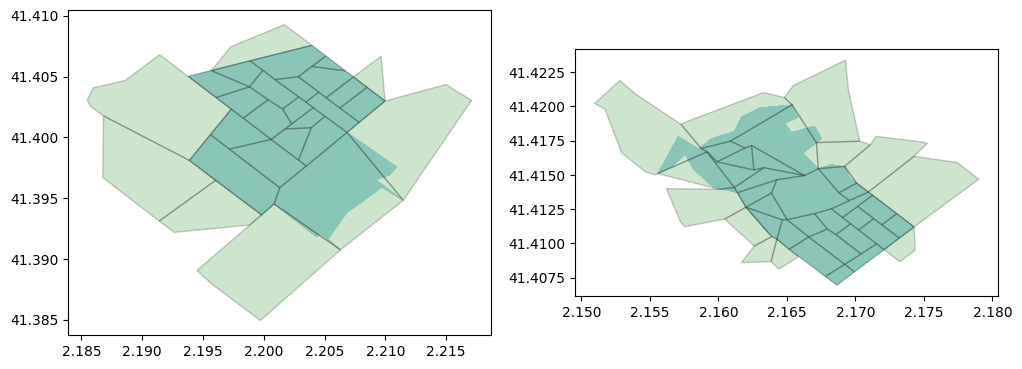

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# plot left geodataframe
map_10131 = df_total[df_total["Index"]==10131].reset_index(drop=True)
base = map_10131.operating_geometry.plot(color="lightblue", alpha=0.3, ax=axs[1])
map_10131.plot(ax=base, color="green", edgecolor='black', alpha=0.2)

# plot right geodataframe
map_10137 = df_total[df_total["Index"]==10137].reset_index(drop=True)
base = map_10137.operating_geometry.plot(color="lightblue", alpha=0.3, ax=axs[0])
map_10137.plot(ax=base, color="green", edgecolor='black', alpha=0.2)

plt.show()



Hence, we have defined two ways to decide which census sections consider and why:

- 3.1. **All inside**: for a given operating zone, consider the census sections that the percentage of overlap is more 70%, and use all the information of the census section as it was completely inside of the operating zone. For example, if a census section that has an average income of 15.000€ and 10.000 people, and it overlaps a 75%, we assume that all of this census section belong to the operating zone, and the 10.000 people will be used for the calculus of the average income.

- 3.2. **Pondered calculus**: for a given operating zone, consider the census sections that the percentage of overlap is more than a 10%, and use the x% of its information. For example, if a census section overlaps a 30% with the operating zone, and it has 10.000 people and 15.000€ of average income, we will consider that 3.000 people belongs to the operating zone we are calculating whith an average income of 15.000€. **Assuming people and salaries are uniformly distributed along the census section.**

### 3.1. All inside

In [ ]:
# filtering only census sections that overlap more that a 70%
df_allinside = df_total[df_total["intersection_pct"]>0.7].reset_index(drop=True)

# total income of a census section
df_allinside["total_rent"] = df_allinside["population"] * df_allinside["rent2017"]

# total income and population of a operating zone
grouped = df_allinside.groupby(by="Index")[["population","total_rent"]].sum().sort_values(by="Index").reset_index()

# average income per person
grouped["average_net_income_per_person"] = grouped["total_rent"] / grouped["population"]
grouped = grouped.drop(columns=["population","total_rent"])
# grouped.to_csv("all_inside_solution.csv", index=False)


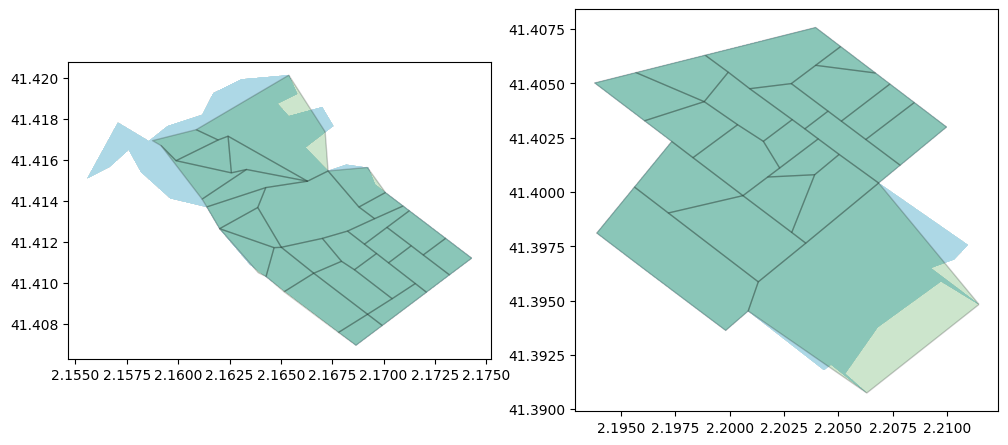

In [13]:
# these are the census sections we are considering in this case
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

map_10131 = df_allinside[df_allinside["Index"]==10131].reset_index(drop=True)
base = map_10131.operating_geometry.plot(color="lightblue", alpha=0.3, ax=axs[0])
map_10131.plot(ax=base, color="green", edgecolor='black', alpha=0.2)

map_10137 = df_allinside[df_allinside["Index"]==10137].reset_index(drop=True)
base = map_10137.operating_geometry.plot(color="lightblue", alpha=0.3, ax=axs[1])
map_10137.plot(ax=base, color="green", edgecolor='black', alpha=0.2)

plt.show()

### 3.2. Pondered Calculus

In [ ]:
# filter census sections that overlap more than a 10%
df_pondered = df_total[df_total["intersection_pct"]> 0.1].reset_index(drop=True)

# calculating pondered population as described before
df_pondered["pondered_population"] = np.floor(df_pondered["population"] * df_pondered["intersection_pct"])

# calculating total incomes, total inhabitants and average rent per person as described, but using the pondered population of every census section
df_pondered["total_rent"] = df_pondered["pondered_population"] * df_pondered["rent2017"]
grouped = df_pondered.groupby(by="Index")[["pondered_population","total_rent"]].sum().sort_values(by="Index").reset_index()
grouped["average_net_income_per_person"] = grouped["total_rent"] / grouped["pondered_population"]
grouped = grouped.drop(columns=["pondered_population","total_rent"])

# grouped.to_csv("pondered_solution.csv", index=False)

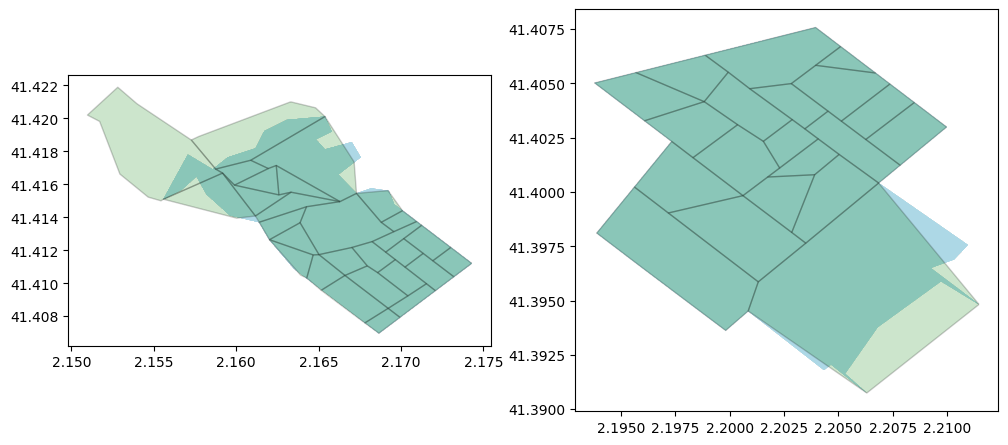

In [15]:
# these are the census sections we are considering in this case
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

map_10131 = df_pondered[df_pondered["Index"]==10131].reset_index(drop=True)
base = map_10131.operating_geometry.plot(color="lightblue", alpha=0.3, ax=axs[0])
map_10131.plot(ax=base, color="green", edgecolor='black', alpha=0.2)

map_10137 = df_pondered[df_pondered["Index"]==10137].reset_index(drop=True)
base = map_10137.operating_geometry.plot(color="lightblue", alpha=0.3, ax=axs[1])
map_10137.plot(ax=base, color="green", edgecolor='black', alpha=0.2)

plt.show()